# Exercise for lecture 7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as image


# Working with skeletons in 2D
Analyse the street skeleton using the binary code kernels from the lecture.

Mainly copying from the lecture:
### 1. Load image and segment it

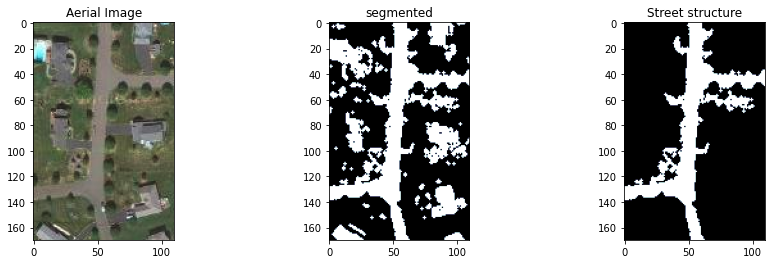

In [3]:
from skimage.io import imread
from skimage.color import rgb2hsv
from skimage.morphology import opening, closing, disk
from skimage.morphology import label
img = imread('../../Lectures/Lecture-07/figures/ny_7.tif')
im_crop = img[250:420:1, 170:280:1]

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,4))

def thresh_image(in_img):
    v_img = rgb2hsv(in_img)[:, :, 2]
    th_img = v_img > 0.4
    op_img = opening(th_img, disk(1))
    return op_img


ax1.imshow(im_crop)
ax1.set_title('Aerial Image')

seg_img = thresh_image(im_crop)
ax2.imshow(seg_img,
           cmap='bone')
ax2.set_title('segmented');

lab_img = label(seg_img)
keep_lab_img = lab_img == 1
ax3.imshow(keep_lab_img, cmap='bone')
ax3.set_title('Street structure');

### 2. Create the skeleton

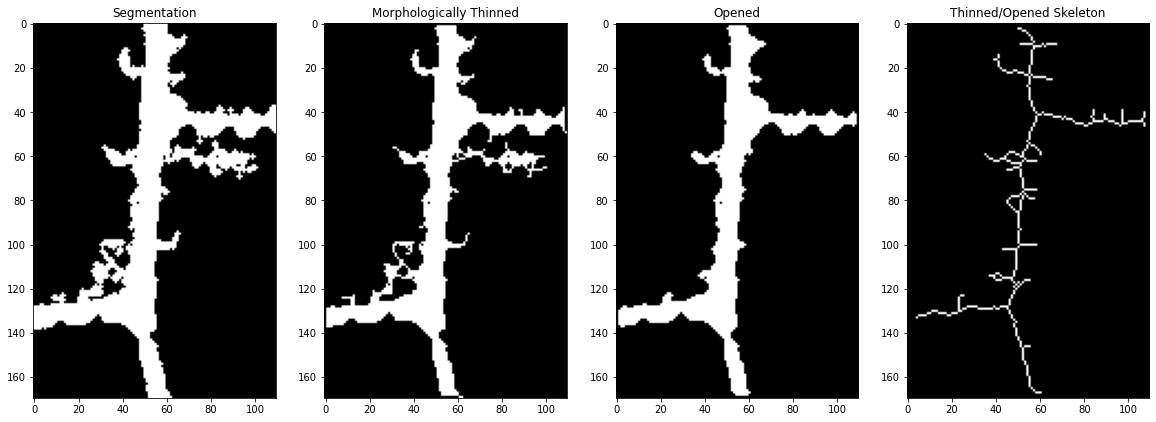

In [4]:
from skimage.morphology import label,skeletonize, medial_axis
from skimage.morphology import thin, erosion


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 7))
ax1.imshow(keep_lab_img, cmap="gray"); ax1.set_title('Segmentation')

thin_image = thin(keep_lab_img, max_iter=1)
ax2.imshow(thin_image, cmap="gray"); ax2.set_title('Morphologically Thinned')

er_thin_image = opening(thin_image, disk(1))
er_thin_image = label(er_thin_image) == 1
ax3.imshow(er_thin_image, cmap="gray"); ax3.set_title('Opened')

opened_skeleton = medial_axis(er_thin_image, return_distance=False)
ax4.imshow(opened_skeleton, cmap="gray"); ax4.set_title('Thinned/Opened Skeleton');

### 3. Prune it using the width criterion

#### Split into segments and label them

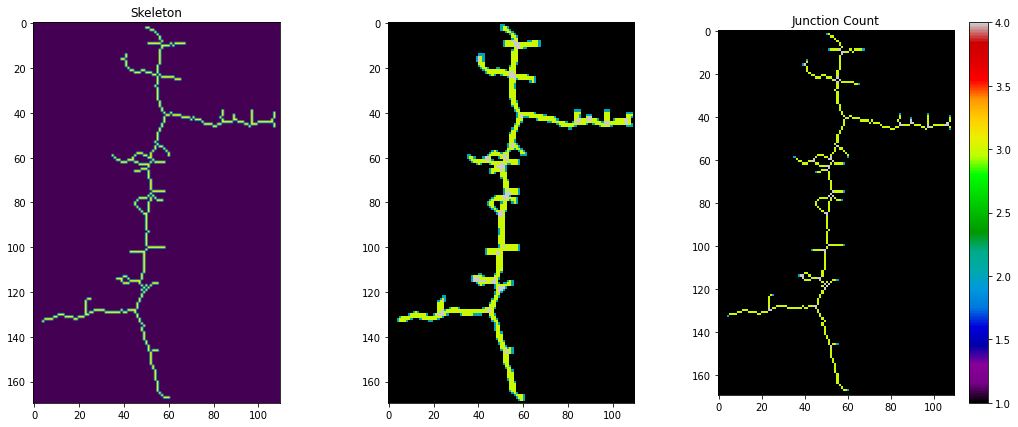

In [5]:
from scipy.ndimage import convolve
from scipy.ndimage import distance_transform_edt


fig, ( ax1, ax3,ax2) = plt.subplots(1, 3, figsize=(18, 7))
ax1.imshow(opened_skeleton)
ax1.set_title('Skeleton')

neighbor_conv = convolve(opened_skeleton.astype(int), np.ones((3, 3)))
ax3.imshow(neighbor_conv,
                   cmap='nipy_spectral',
                   vmin=1, vmax=4,
                   interpolation='none' )
neighbor_conv[~opened_skeleton] = 0
j_img = ax2.imshow(neighbor_conv,
                   cmap='nipy_spectral',
                   vmin=1, vmax=4,
                   interpolation='none')
plt.colorbar(j_img)
ax2.set_title('Junction Count');

#### Measure  segment thickness

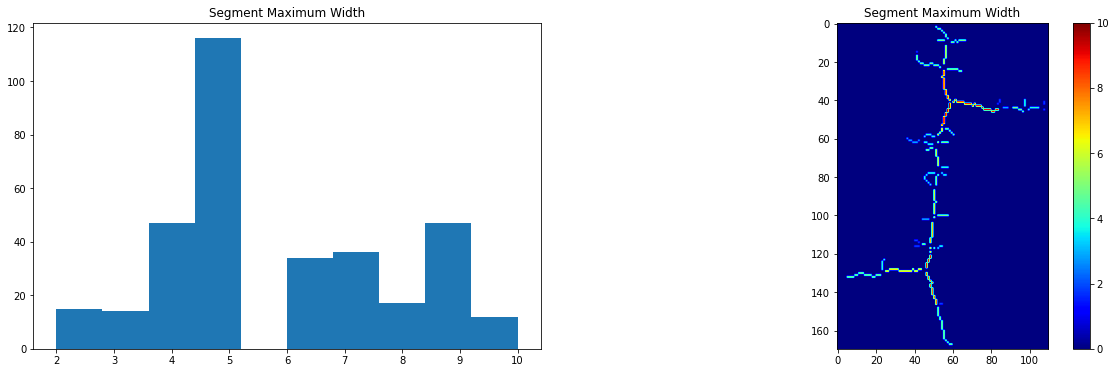

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

lab_seg = label(neighbor_conv == 3)

dist_map = distance_transform_edt(keep_lab_img)

label_width_img = np.zeros_like(lab_seg)
for i in np.unique(lab_seg[lab_seg > 0]):
    label_width_img[lab_seg == i] = np.max(dist_map[lab_seg == i])

ax1.hist(label_width_img[label_width_img > 0])
ax1.set_title('Segment Maximum Width')


ll_ax = ax2.imshow(label_width_img, cmap='jet')
ax2.set_title('Segment Maximum Width'); plt.colorbar(ll_ax);

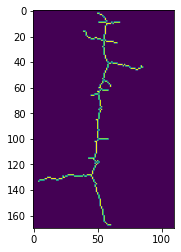

In [7]:
width_skeleton =  (label_width_img > 4.5) \
                + (neighbor_conv == 2) \
                + (neighbor_conv > 3)
width_skeleton = label(width_skeleton) == 1

plt.imshow(width_skeleton);

3. Convolve skeleton by 4- and 8-connected masks.

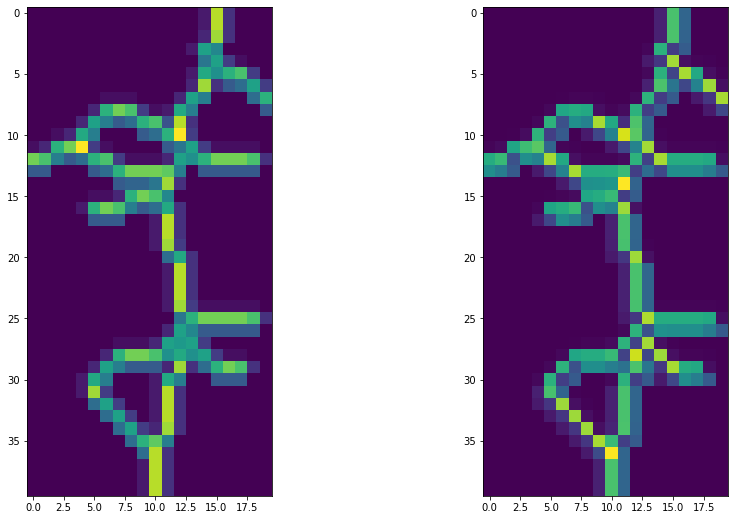

In [8]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 9))
n_crop = neighbor_conv[50:90, 40:60]
      
neighbor_j4 = convolve(opened_skeleton[50:90, 40:60].astype(int), np.array([[0,1,0],[2,16,4],[0,8,0]]))
neighbor_j8 = convolve(opened_skeleton[50:90, 40:60].astype(int), np.array([[1,2,4],[8,256,16],[32,64,128]]))
ax1.imshow(neighbor_j4)

ax2.imshow(neighbor_j8)

4. Extract skeleton from resulting image

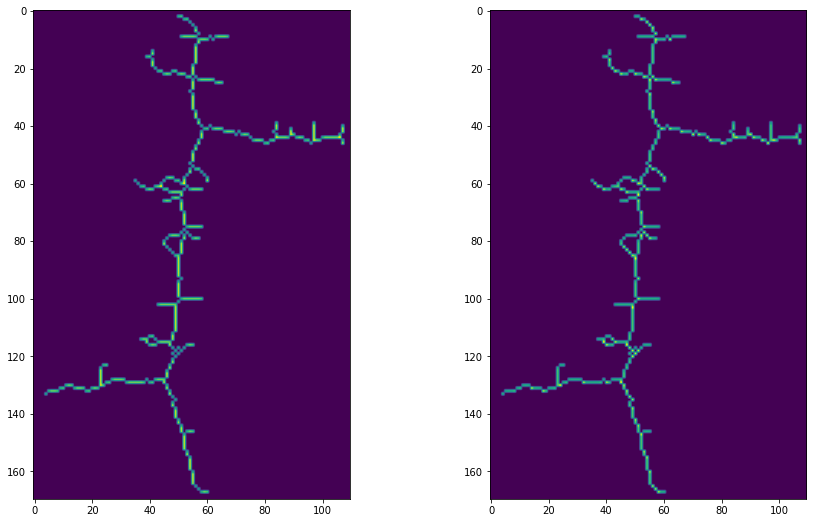

In [9]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 9))
n_crop = neighbor_conv[50:90, 40:60]
      
neighbor_j4 = convolve(opened_skeleton.astype(int), np.array([[0,1,0],[2,16,4],[0,8,0]])) * opened_skeleton
neighbor_j8 = convolve(opened_skeleton.astype(int), np.array([[1,2,4],[8,256,16],[32,64,128]])) * opened_skeleton
ax1.imshow(neighbor_j4)

ax2.imshow(neighbor_j8)

## Task
### 1. Identify directions of end points.
The end points are identified by specific combinations for 4- and 8-connected neighborhods
#### 4-connected 
The endpoints have the following codes: 
- Up - 24
- Down - 17
- Left - 20
- Right - 18

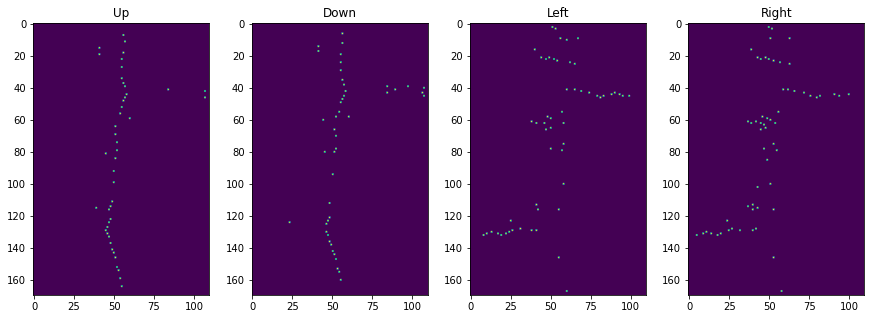

In [10]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5))

ax1.imshow(neighbor_j4 ==24), ax1.set_title('Up');
ax2.imshow((neighbor_j4 ==17)), ax2.set_title('Down');
ax3.imshow(neighbor_j4 ==20), ax3.set_title('Left');
ax4.imshow((neighbor_j4 ==18)), ax4.set_title('Right');

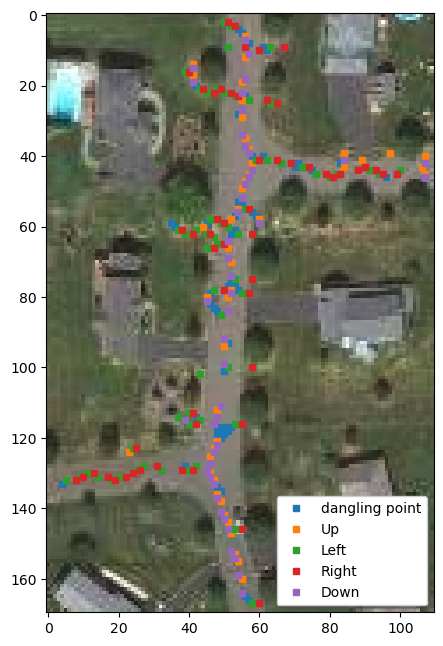

In [11]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5,10), dpi=100)
ax1.imshow(im_crop)
j_name = {16: 'dangling point', 24 : 'Down',
          17: 'Up', 20: 'Right', 18: 'Left'}
for j_count in np.unique(neighbor_j4[neighbor_j4 > 0]):
    if j_count in j_name :
        y_c, x_c = np.where(neighbor_j4 == j_count)
        ax1.plot(x_c, y_c, 's',
             label=j_name.get(j_count, 'unknown'),
             markersize=5)

leg = ax1.legend(shadow=True, fancybox=True, frameon=True)

We can here see that the 4-connected neighborhood detects much more that only end points. It also sees every time the skeleton makes a turn.

#### 8-connected 
This case also allows the diagonals

The endpoints have the following codes: 
- Up - 320
- Down - 258
- Left - 272
- Right - 264


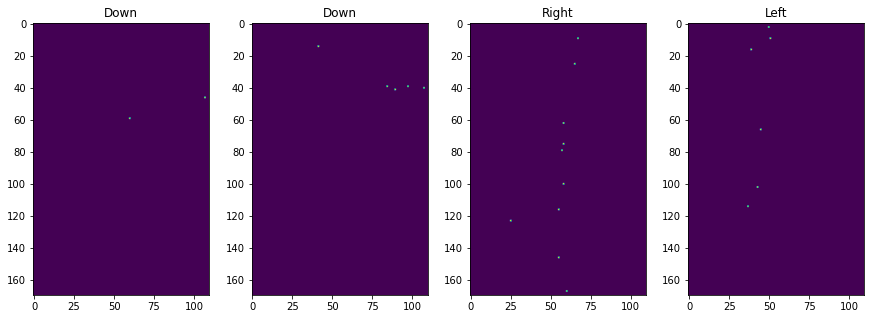

In [12]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5))

ax1.imshow(neighbor_j8 == 320), ax1.set_title('Down');
ax2.imshow(neighbor_j8 == 258), ax2.set_title('Down');
ax3.imshow(neighbor_j8 == 272), ax3.set_title('Right');
ax4.imshow(neighbor_j8 == 264), ax4.set_title('Left');

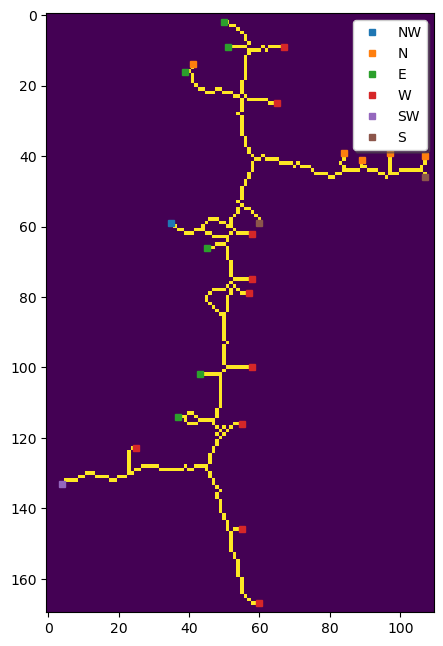

In [13]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5,10), dpi=100)
ax1.imshow(opened_skeleton)
j_name = {256: 'dangling point', 320: 'S', 258: 'N',
          272: 'W', 264: 'E', 
          257 : 'NW', 288 : 'SW',
          260 : 'NE', 384 : 'SE'}
for j_count in np.unique(neighbor_j8[neighbor_j8 > 0]):
    if j_count in j_name :
        y_c, x_c = np.where(neighbor_j8 == j_count)
        ax1.plot(x_c, y_c, 's',
             label=j_name.get(j_count, 'unknown'),
             markersize=5)

leg = ax1.legend(shadow=True, fancybox=True, frameon=True)

### 2. Count how many different junction points there are.
We two type of junctions: X and Y

#### X-junctions
There are only two types of X junctions. 

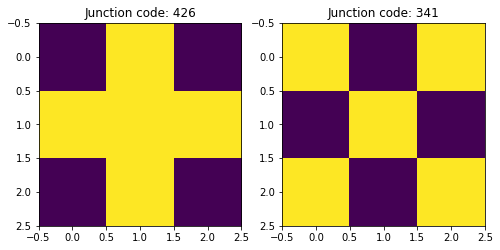

In [14]:
junctions = []
junctions.append([[0,1,0],[1,1,1],[0,1,0]])
junctions.append([[1,0,1],[0,1,0],[1,0,1]])

# Let's modify the mask a bit to fit our purpose
mask=np.array([ [1,     2,  4],
                [128, 256,  8],
                [64,   32, 16]])
jcodes = []
fig, axes = plt.subplots(1,2,figsize=(8,4))

for ax,junction in zip(axes.flat,junctions[:2]) :
    ax.imshow(junction)
    jcodes.append((np.array(junction)*mask).sum())
    ax.set_title('Junction code: {}'.format(jcodes[-1]))

#### Simple Y-junctions
The simple Y-junctions only connect in with a single pixel in each direction. We start giving some combinations here.

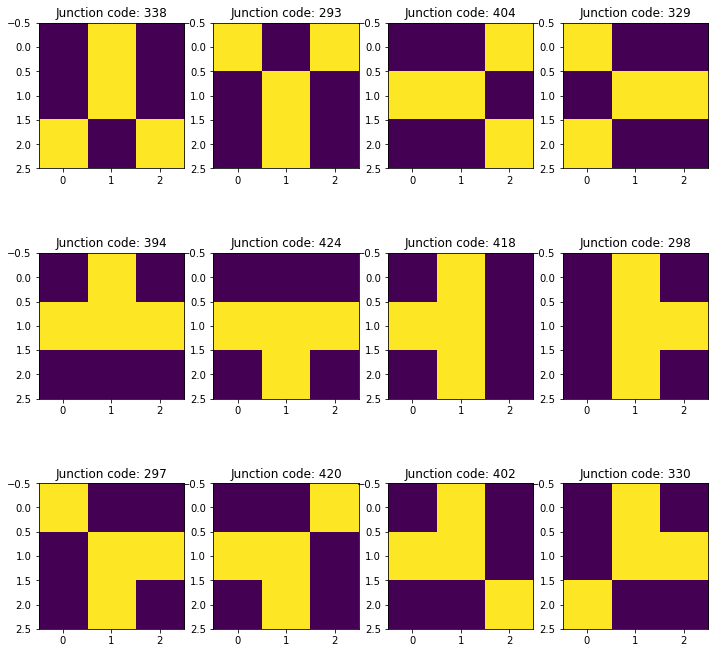

In [15]:
junctions.append([[0,1,0],
                  [0,1,0],
                  [1,0,1]])
junctions.append([[1,0,1],
                  [0,1,0],
                  [0,1,0]])
junctions.append([[0,0,1],
                  [1,1,0],
                  [0,0,1]])
junctions.append([[1,0,0],
                  [0,1,1],
                  [1,0,0]])

junctions.append([[0,1,0],
                  [1,1,1],
                  [0,0,0]])
junctions.append([[0,0,0],
                  [1,1,1],
                  [0,1,0]])
junctions.append([[0,1,0],
                  [1,1,0],
                  [0,1,0]])
junctions.append([[0,1,0],
                  [0,1,1],
                  [0,1,0]])

junctions.append([[1,0,0],
                  [0,1,1],
                  [0,1,0]])
junctions.append([[0,0,1],
                  [1,1,0],
                  [0,1,0]])
junctions.append([[0,1,0],
                  [1,1,0],
                  [0,0,1]])
junctions.append([[0,1,0],
                  [0,1,1],
                  [1,0,0]])

fig, axes = plt.subplots(3,4,figsize=(12,12))

for ax,junction in zip(axes.flat,junctions[2:]) :
    ax.imshow(junction)
    jcodes.append((np.array(junction)*mask).sum())
    ax.set_title('Junction code: {}'.format(jcodes[-1]))
    

As you see, these are only subset of all combinations leading to a 3-way junctions. 
If you like you can do the analysis based this subset

#### Complicated Y-junctions (advanced)
Thing get more complicated and we would need a long look-up table to cover all possible combinations that also include several pixels leading to the same branch. What we could do instead is to write a function that counts the number of bit flips which is directly related to the number of branches. This is done as a state machine that iterates over the bit positions in neighborhood code.

In [16]:
def countBranches(x) :
    if 255<x :
        x = x & 255 # mask out the center pixel
    else :
        return 0
    
    cnt = 0   
    prev_state    = (x & 128) >>7  # 
    
    for i in range(8) :
        current_state = x & 1   #  look at the lowest bit
        if (current_state != prev_state) and current_state == 1 :
            cnt +=1
    #    print("x:{0:08b}, cnt:{1} ({2}->{3})".format(x,cnt, prev_state, current_state))
        prev_state = current_state
        x = x >> 1

        
    return cnt
   
# Lets do some tests:
for code in jcodes :
    print(code,countBranches(code))

426 4
341 4
338 3
293 3
404 3
329 3
394 3
424 3
418 3
298 3
297 3
420 3
402 3
330 3


### Count different pixel constellations


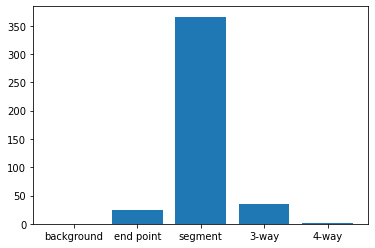

In [17]:
coded_neighbors = convolve(opened_skeleton.astype(int), mask) * opened_skeleton

cnt = np.zeros(5)
lbls = ['background','end point','segment','3-way','4-way']

for pixel in coded_neighbors[coded_neighbors !=0].flat :
    branches = countBranches(pixel)
    if branches<5 :
        cnt[branches]+=1
        
plt.bar(lbls,cnt);

### 3. What happens to the codes at the loop in the lower 
Look at coordinated [110:120,36:45]

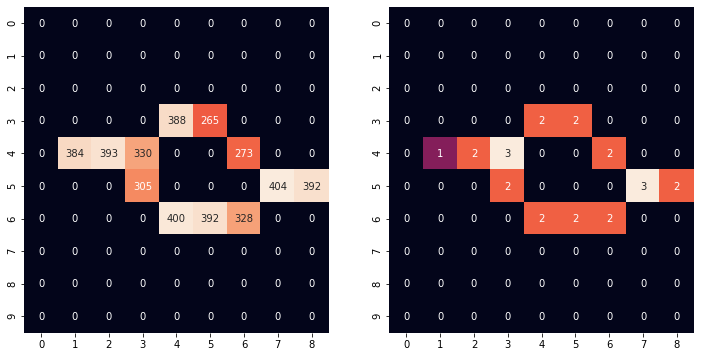

In [18]:
import seaborn as sns
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
cimg = coded_neighbors[110:120,36:45]
sns.heatmap(cimg, annot=True, fmt="d", ax=ax1, cbar=False)
counter_img = np.zeros(cimg.shape)

for j_count in np.unique(cimg[cimg > 0]):
    
    y_c, x_c = np.where(cimg == j_count)
    for y,x in zip(y_c,x_c) :
        counter_img[y,x]=countBranches(cimg[y,x])
        
sns.heatmap(counter_img, annot=True, ax=ax2, cbar=False);


# Working with skeletons in 3D
Analyse the root network in terms of 
- Distance between branches
- Turtosity
- Root segment position
- Root segment angle in the vertical direction.


### Recommended steps
1. Load the root image (you have to unpack the zip file before starting)

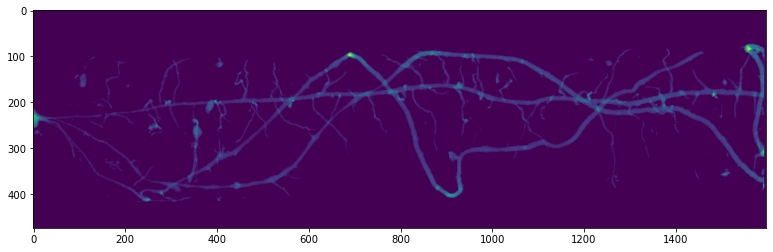

In [20]:
root = np.load('../../Lectures/Lecture-07/data/Cropped_prediction_8bit.npy')
plt.figure(figsize=(15,4))
plt.imshow(root.mean(axis=0))

### 2. Clean the segmented image from disconnected fragments
1. Label 
2. measure volume of each item (we use the histogram here)
3. extract the largest item 

In [21]:
lbl_root = label(root)

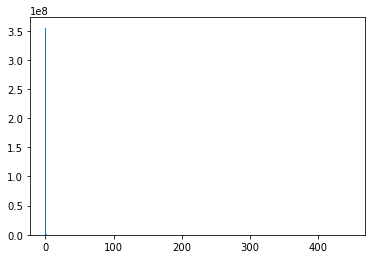

In [22]:
a=plt.hist(lbl_root.ravel(),bins=np.unique(lbl_root));

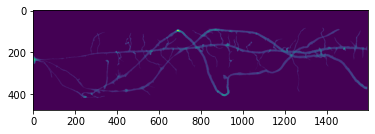

In [23]:
idx = 1 # we need to exclude the 0 label which is the background
main_root = (lbl_root==a[1][np.argmax(a[0][idx:])+idx])
plt.imshow(main_root.mean(axis=0));

### 3. Compute skeleton

In [24]:
from skimage.morphology import skeletonize_3d
root_skel = skeletonize_3d(main_root)

### 4. Break it apart (use convolution with 3x3x3)
We can't use the coding from the previous exercise because the third dimensions makes the bit flip analysis very complicated

In [25]:
root_coded = root_skel * convolve(root_skel, np.ones([3,3,3]))

Let's look at the histogram to identify what the different codes correspond to 

(array([  154., 10915.,   299.]),
 array([2, 3, 4, 5], dtype=uint8),
 <BarContainer object of 3 artists>)

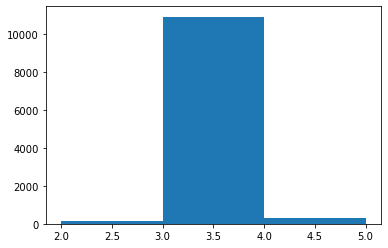

In [26]:
u=np.unique(root_coded)
plt.hist(root_coded[0<root_coded].ravel(),bins=u[1:])

We can now interpret the codes as:
2. End points
3. Root segments
4. Junctions


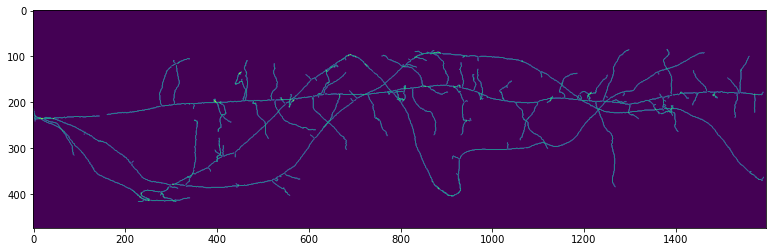

In [27]:
plt.figure(figsize=(15,4))
plt.imshow((root_coded==3).max(axis=0),cmap='viridis');

### 5. Label segments
Let's label the items with code 3 (root segments)

In [28]:
root_segments = label(root_coded==3)
seg_hist = np.histogram(root_segments[0<root_segments].ravel(),bins=np.unique(root_segments)[1:]);


Now lets look at the distribution of segment lengths, i.e. counting the pixels for each segment

13.76% of the segments represent 50% of the length


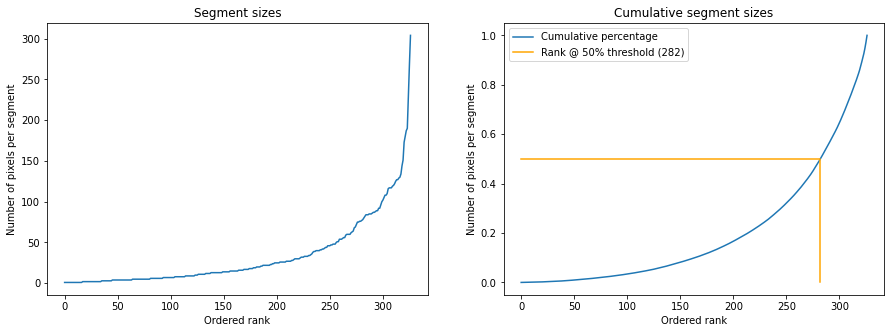

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(np.sort(seg_hist[0]))
ax1.set_title('Segment sizes')
ax1.set_ylabel('Number of pixels per segment')
ax1.set_xlabel('Ordered rank')

cs = np.cumsum(np.sort(seg_hist[0])) 
cs = cs/cs.max()
pos50 = np.min(np.where(0.5<=cs))
ax2.plot(cs, label = 'Cumulative percentage')
ax2.plot([0,pos50,pos50],[0.5, 0.5,0.0],color='orange',label = 'Rank @ 50% threshold ({0})'.format(pos50))
ax2.legend()
ax2.set_title('Cumulative segment sizes')
ax2.set_ylabel('Number of pixels per segment')
ax2.set_xlabel('Ordered rank');

print("{0:0.2f}% of the segments represent 50% of the length".format(100*(1 - pos50/len(cs))))

This analysis tells us that the root system consists of a main trunk from which smaller branches grow.

### 6. Run analysis for each segment (advanced)
First, we must bring the segment information into a data frame. We want to store the following information in the frame:
1. Label
2. Length (count pixels in segment)
3. Position x,y,z (from moments $\mu_{1,0,0}$ $\mu_{0,1,0}$ $\mu_{0,0,1}$)
4. Moments for three axes $\mu_{1,1,0}$ $\mu_{1,0,1}$ $\mu_{0,1,1}$ $\mu_{2,0,0}$ $\mu_{0,2,0}$ $\mu_{0,0,2}$

In [30]:
import pandas as pd # now, we need the data frames

#we need moment function that meets our needs in the workflow
def moment(xx,yy,zz,k,l,m) :
    mu = 0;
    for x,y,z in zip(xx,yy,zz) :
        mu += x**k * y**l * z**m 
        
    return mu

In [31]:
rows_list = []

#subvol = root_segments[:,:,600:700]
subvol = root_segments
for lbl in np.unique(subvol) :
    if 0<lbl : 
        x_c, y_c, z_c = np.where(subvol ==lbl)
        
        m110 = moment(x_c,y_c,z_c,1,1,0)
        m101 = moment(x_c,y_c,z_c,1,0,1)
        m011 = moment(x_c,y_c,z_c,0,1,1)
        m200 = moment(x_c,y_c,z_c,2,0,0)
        m020 = moment(x_c,y_c,z_c,0,2,0)
        m002 = moment(x_c,y_c,z_c,0,0,2)
        row_dict = {"labels": lbl,
                    "length": len(z_c),
                    "posX": moment(x_c,y_c,z_c,1,0,0)/len(x_c),
                    "poxY": moment(x_c,y_c,z_c,0,1,0)/len(x_c),
                    "posZ": moment(x_c,y_c,z_c,0,0,1)/len(x_c),
                    "m110": m110,
                    "m101": m101,
                    "m011": m011,
                    "m200": m200,
                    "m020": m020,
                    "m002": m002,
                    "thxy": 0.5*np.arctan2(2*m110,(m200-m020)),
                    "thxz": 0.5*np.arctan2(2*m101,(m200-m002)),
                    "thyz": 0.5*np.arctan2(2*m011,(m020-m002))}

        rows_list.append(row_dict)
        
df = pd.DataFrame(rows_list)

In [32]:
df.head()

,labels,length,posX,poxY,posZ,m110,m101,m011,m200,m020,m002,thxy,thxz,thyz
0,1,8,76.250000,273.875000,607.500000,167087,370603,1331067,46532,600089,2952492,1.299234,1.445927,1.147253
1,2,231,84.038961,254.060606,1181.367965,4932690,22927158,68796997,1636125,15306060,323217312,1.258231,1.499979,1.360675
2,3,119,82.336134,258.411765,494.529412,2531329,4845718,15093238,807394,8054811,29222731,1.265921,1.406451,1.091177
3,4,92,82.706522,235.945652,653.739130,1789769,4980444,14139279,630253,5171363,39372284,1.237028,1.444968,1.225351
4,5,82,96.975610,318.426829,582.743902,2551601,4617747,15182890,780720,8354861,27874129,1.274345,1.406535,1.071048


#### Measure the angles
- Angle of a 2D object:
$$ \theta = \frac{1}{2} tan^{-1}\left( \frac{2\cdot\mu_{1,1}}{\mu_{2,0}-\mu_{0,2}}\right)$$
where the moments are described by
$$\mu_{m,n}=\sum_{i,j}x_i^m\,y_j^n\,v_{i,j}$$
      see
```
skimage.measure.moments_central(image, center=None, order=3, **kwargs)
```

### 7. Use pair plot to see if there are any interesting correlations 
``` 
import seaborn as sns
sns.pairplot(df,
             kind="reg")
             ```

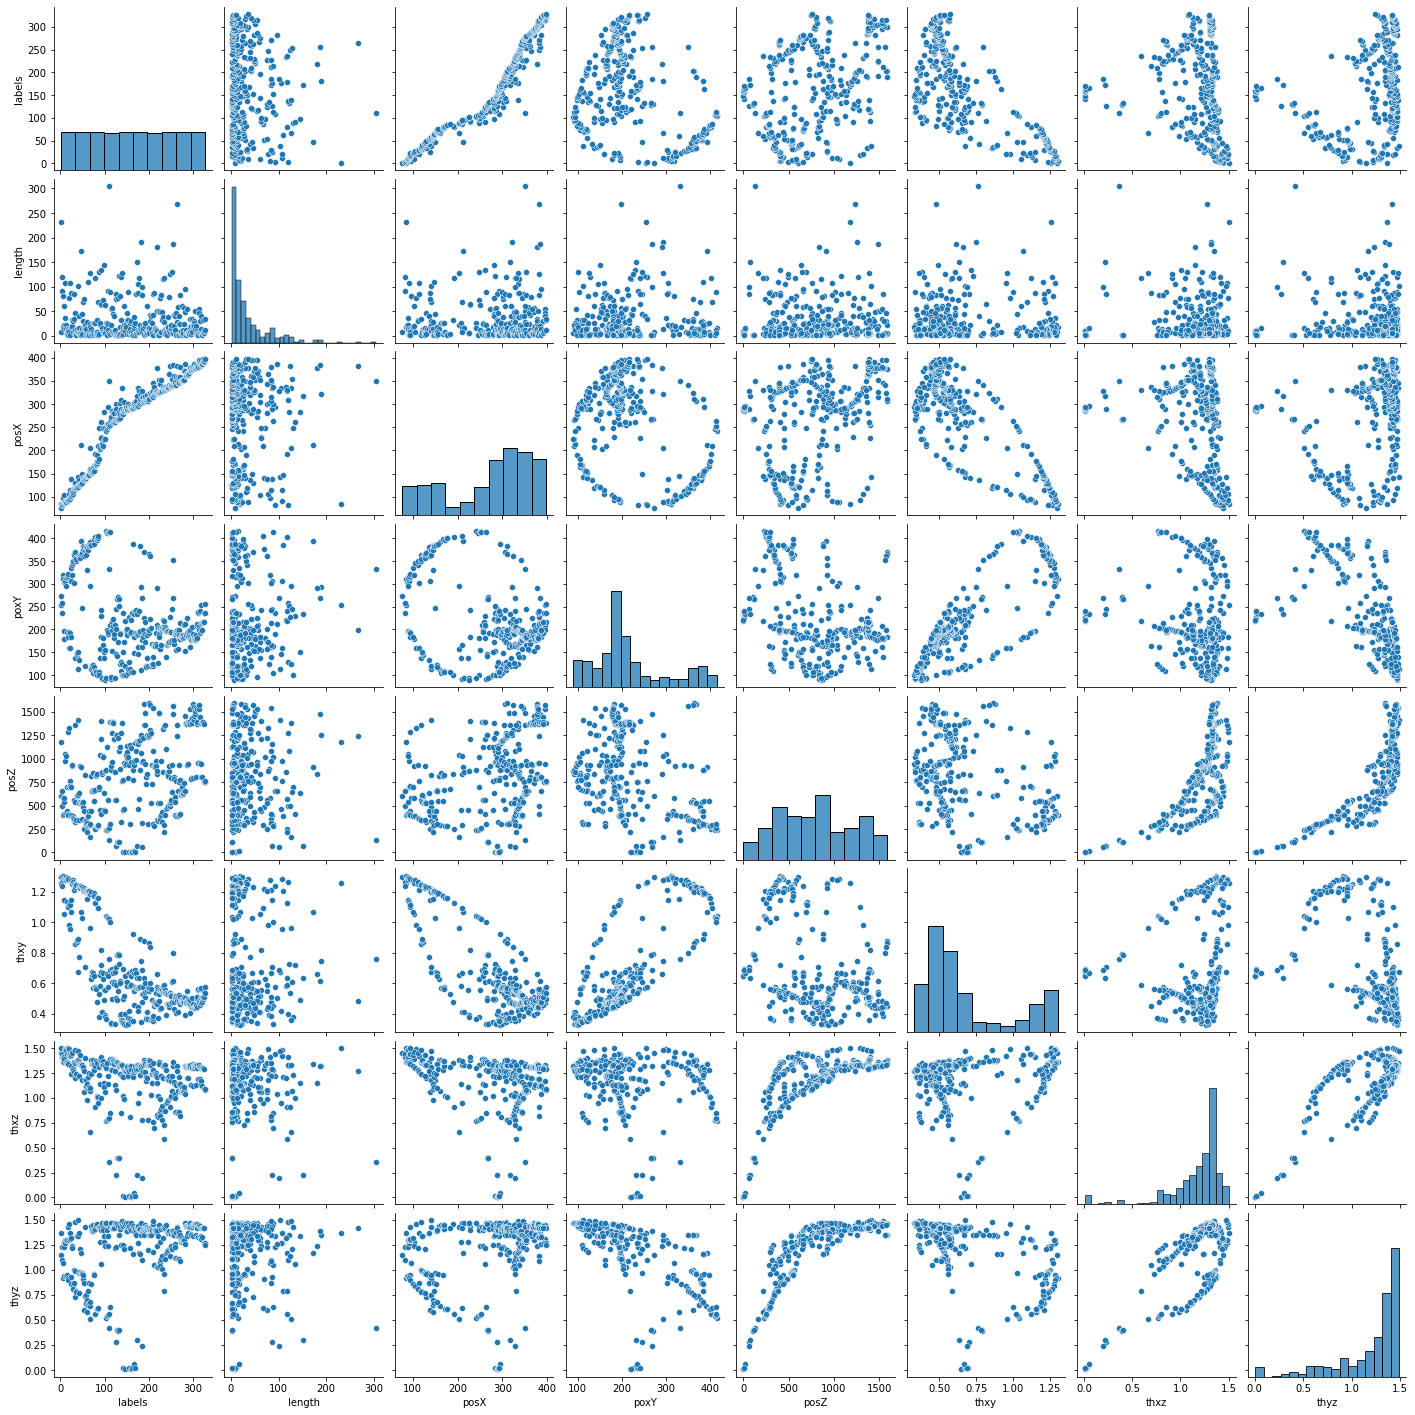

In [33]:
import seaborn as sns
vars = ["labels",
"length",
"posX",
"poxY",
"posZ",
#"m110",
#"m101",
#"m011",
#"m200",
#"m020",
#"m002",
"thxy",
"thxz",
"thyz"]
sns.pairplot(df, vars=vars)

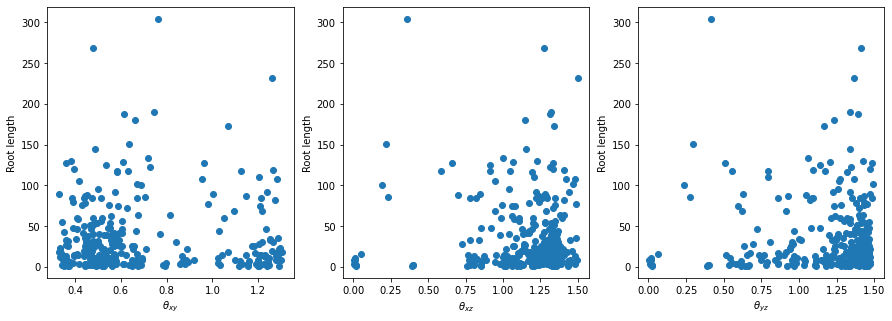

In [34]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.scatter(df['thxy'],df['length'])
ax1.set_ylabel('Root length')
ax1.set_xlabel(r'$\theta_{xy}$');

ax2.scatter(df['thxz'],df['length'])
ax2.set_ylabel('Root length')
ax2.set_xlabel(r'$\theta_{xz}$');

ax3.scatter(df['thyz'],df['length'])
ax3.set_ylabel('Root length')
ax3.set_xlabel(r'$\theta_{yz}$');

__Conclusion__: Long roots have more consistent direction than short roots.